In [1]:
from instant_ack import *
import dateutil

%load_ext autoreload
%autoreload 2

2024-09-12 01:18:01.068 | INFO     | instant_ack.config:<module>:11 - PROJ_ROOT path is: /data/instant-ack


# Load data

In [2]:
df = (
    preprocess_qscanner.translate_frame_types(
        cv.load_data("cloudflare"), "quic.frame_type", "frame_type"
    )
    .filter(~pl.col("quic.scid").is_null())
    .drop_nulls("quic.frame_type")
    .sort(["measurement_ts", "location"])
)

df = preprocess_qscanner.location_to_titlecase(df)

unique_responses = ["measurement_ts", "quic.dcid", "location"]
unique_requests = ["measurement_ts", "quic.scid", "location"]

In [3]:
req = df.filter(pl.col("kind") == "requests")

responses = (
    cv.classify_ack_and_sh_frames(df, unique_responses)
    .filter(
        pl.col("ack_first") | pl.col("sh_first"),
        # Use only packets where the first ack from the server is received
        pl.col("first_ack_number"),
    )
    .filter(
        (pl.col("ack_first") & pl.col("sh_first"))
        | (pl.len().over(unique_responses) == 2),
    )
)

In [4]:
# Add request packet sent time
send_ts = req.group_by(unique_requests).agg(pl.col("ts").min())

responses = responses.join(
    send_ts,
    how="inner",
    left_on=unique_responses,
    right_on=unique_requests,
    validate="m:1",
    suffix="_sent",
).with_columns(
    ts_diff=(pl.col("ts") - pl.col("ts_sent")).dt.total_microseconds() / 1000
)

In [5]:
airport_to_city = {
    "HAM": "Hamburg",
    "LAX": "Los Angeles",
    "HKG": "Hongkong",
    "GRU": "Sao Paulo",
}

In [6]:
# Add Response Cf-Ray response headers
# https://developers.cloudflare.com/fundamentals/reference/http-request-headers/#cf-ray
headers = (
    cv.load_data("cloudflare.header", skip_missing=True)
    .collect()
    .filter(pl.col("Header") == "Cf-Ray")
    .with_columns(
        pl.col("measurement_ts")
        .str.replace_all(",", ".")
        .str.to_datetime()
        .dt.replace_time_zone(None),
        ray_location=pl.col("Value").str.reverse().str.slice(1, 3).str.reverse(),
    )
)

responses = (
    responses.with_columns(
        pl.col("measurement_ts").dt.round(every="1h").name.suffix("_round"),
        targetid=pl.col("quic.dcid").str.slice(2).str.to_integer(base=16),
    )
    .join(
        headers.lazy().select("ray_location", "targetid", "measurement_ts", "location"),
        on=["targetid", "measurement_ts", "location"],
        how="left",
        validate="m:1",
    )
    .with_columns(pl.col("ray_location").replace(airport_to_city).name.suffix("_name"))
)

In [7]:
filtered_responses = (
    responses.filter(
        # Use only responses from the same location as the measurement node
        pl.col("geo_location")
        == pl.col("ray_location_name"),
    )
    .filter(
        # ACK and SH in one packet or ack and sh in separate packets, but definitely two packets then
        (pl.col("ack_first") & pl.col("sh_first"))
        | (pl.len().over(unique_responses) == 2),
    )
    .with_columns(pl.col("frame_type").str.replace("CRYPTO", "SH"))
    .select(
        "measurement_ts",
        "frame_type",
        "ts_diff",
        "location",
        "geo_location",
        "ray_location_name",
        "sni",
        "sh",
        "ts",
        "quic.dcid",
    )
    .collect()
)

# Plot

Hamburg


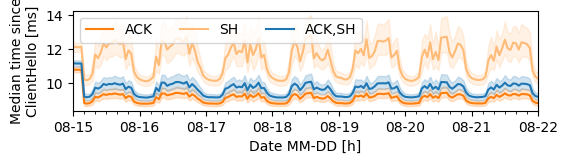

Hongkong


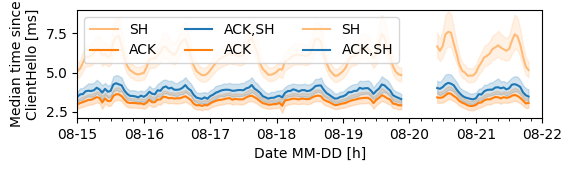

Sao Paulo


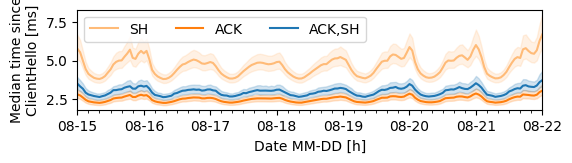

Los Angeles


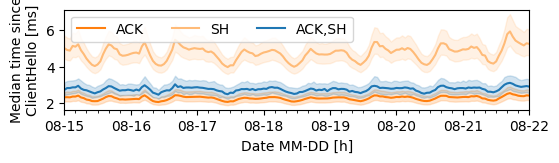

In [8]:
for gname, group in (
    filtered_responses.select("measurement_ts", "frame_type", "ts_diff", "geo_location")
    .with_columns(pl.col("measurement_ts").dt.round(every="1h"))
    .filter(
        pl.col("measurement_ts") >= datetime(2024, 8, 15),
        pl.col("measurement_ts") <= datetime(2024, 8, 22),
    )
    .group_by("geo_location", maintain_order=True)
):
    print(gname[0])

    if "Hongkong" in gname[0]:
        fig, ax = vh.fig_ax()
        plot.line(
            group.filter(pl.col("measurement_ts") <= datetime(2024, 8, 19, 21)),
            x="measurement_ts",
            y="ts_diff",
            hue="frame_type",
            estimator="median",
            errorbar=("pi", 50),
            xlim=(datetime(2024, 8, 15), datetime(2024, 8, 22)),
            fig=fig,
            ax=ax,
            legend=False,
        )
        plot.line(
            group.filter(
                pl.col("measurement_ts") >= datetime(2024, 8, 20, 10),
                pl.col("measurement_ts") <= datetime(2024, 8, 21, 19),
            ),
            x="measurement_ts",
            y="ts_diff",
            hue="frame_type",
            estimator="median",
            errorbar=("pi", 50),
            dest=f"cloudflare/lin_cloudflare_ack_sh_{gname[0].replace(" ", "_")}",
            xlim=(datetime(2024, 8, 15), datetime(2024, 8, 22)),
            fig=fig,
            ax=ax,
            legend=True,
            legend_pos="upper left",
        )
    else:
        plot.line(
            group,
            x="measurement_ts",
            y="ts_diff",
            hue="frame_type",
            dest=f"cloudflare/lin_cloudflare_ack_sh_{gname[0].replace(" ", "_")}",
            estimator="median",
            errorbar=("pi", 50),
            xlim=(datetime(2024, 8, 15), datetime(2024, 8, 22)),
            legend=True,
            legend_pos="upper left",
        )
    plt.show()

### ACK-SH delay for vantage point Sao Paulo: Section 4.3, Figure 9

In [9]:
location = "Sao Paulo"
group = (
    filtered_responses.select("measurement_ts", "frame_type", "ts_diff", "geo_location")
    .with_columns(pl.col("measurement_ts").dt.round(every="1h"))
    .filter(
        pl.col("measurement_ts") >= datetime(2024, 8, 15),
        pl.col("measurement_ts") <= datetime(2024, 8, 22),
        pl.col("geo_location") == location,
    )
)

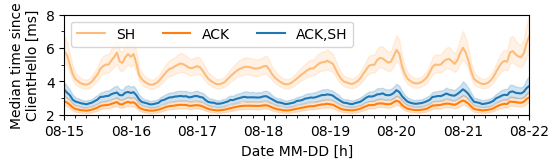

In [10]:
plot.line(
    group,
    x="measurement_ts",
    y="ts_diff",
    hue="frame_type",
    dest=f"cloudflare/lin_cloudflare_ack_sh_{location.replace(" ", "_")}",
    estimator="median",
    errorbar=("pi", 50),
    ylabel="Median time since\nClientHello [ms]",
    xlim=(datetime(2024, 8, 15), datetime(2024, 8, 22)),
    ylim=(2, 8),
    yMajorLocator=ticker.MultipleLocator(2),
    yMinorLocator=ticker.MultipleLocator(1),
    legend=True,
    legend_pos="upper left",
)

### ACK-SH delay for all vantage points: Appendix G, Figure 13

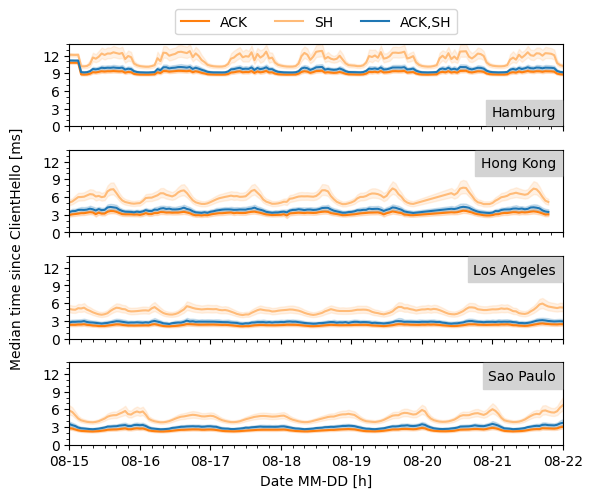

In [11]:
plot.multi(
    filtered_responses.select("measurement_ts", "frame_type", "ts_diff", "geo_location")
    .with_columns(
        pl.col("measurement_ts").dt.round(every="1h"),
        pl.col("geo_location").replace("Hongkong", "Hong Kong"),
    )
    .filter(
        pl.col("measurement_ts") >= datetime(2024, 8, 15),
        pl.col("measurement_ts") <= datetime(2024, 8, 22),
    )
    .sort("geo_location"),
    "geo_location",
    figsize=(6, 3 * 1.7),
    x="measurement_ts",
    y="ts_diff",
    hue="frame_type",
    xlabel="Date MM-DD [h]",
    legend_pos="upper center",
    legend_ncol=3,
    bbox_to_anchor=(0.5, 1.5),
    auto_scale_x=False,
    inner=plot.line,
    anc_text_prefix="",
    anc_text_suffix="",
    ylim=(0, 14),
    yMajorLocator=ticker.MultipleLocator(3),
    yMinorLocator=ticker.MultipleLocator(1),
    ylabel=None,
    supylabel=f"Median time since ClientHello [ms]",
    anc_loc="upper right",
    first_anc_loc="lower right",
    estimator="median",
    errorbar=("pi", 50),
    dest="cloudflare/lin_cloudflare_ack_sh_intervals_all_locations_with_pi_50",
    hk_special=True,
)

## Details

In [12]:
ack_sh_delay = (
    filtered_responses.with_columns(
        diff_ms=(pl.col("ts").max() - pl.col("ts").min())
        .over(unique_responses)
        .dt.total_microseconds()
        / 1000,
        classification=pl.when(pl.col("sh"))
        .then(pl.lit("ACK,SH"))
        .otherwise(pl.lit("IACK")),
    ).sort("frame_type")
    # required to make sure every domain has weight 1
    .unique(unique_responses, keep="first")
)

### Median delay between ACK and SH: Section 4.3

In [13]:
ack_sh_delay.filter(pl.col("classification") == "IACK").select(
    pl.col("diff_ms").mean().alias("mean"),
    pl.col("diff_ms").median().alias("median"),
    pl.col("diff_ms").std().alias("std"),
    pl.col("diff_ms").quantile(0.5).alias("50%"),
    pl.col("diff_ms").quantile(0.95).alias("95%"),
    pl.col("diff_ms").quantile(0.99).alias("99%"),
)

mean,median,std,50%,95%,99%
f64,f64,f64,f64,f64,f64
2.607743,2.271,6.077603,2.271,4.503,6.695


In [14]:
ack_sh_delay.filter(pl.col("classification") == "IACK").group_by("geo_location").agg(
    pl.col("diff_ms").mean().alias("iack_mean"),
    pl.col("diff_ms").median().alias("iack_median"),
    pl.col("diff_ms").std().alias("iack_std"),
    pl.col("diff_ms").quantile(0.5).alias("iack_50%"),
    pl.col("diff_ms").quantile(0.95).alias("iack_95%"),
    pl.col("diff_ms").quantile(0.99).alias("iack_99%"),
    pl.col("ts_diff").mean().alias("rtt_mean"),
    pl.col("ts_diff").median().alias("rtt_median"),
    pl.col("ts_diff").std().alias("rtt_std"),
    pl.col("ts_diff").quantile(0.5).alias("rtt_50%"),
    pl.col("ts_diff").quantile(0.95).alias("rtt_95%"),
    pl.col("ts_diff").quantile(0.99).alias("rtt_99%"),
)

geo_location,iack_mean,iack_median,iack_std,iack_50%,iack_95%,iack_99%,rtt_mean,rtt_median,rtt_std,rtt_50%,rtt_95%,rtt_99%
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Hamburg""",2.449984,2.124,2.000001,2.124,4.955,7.495,9.328733,9.085,5.619247,9.085,10.528,11.785
"""Sao Paulo""",2.39153,2.08,6.039881,2.08,3.922,5.871,2.704714,2.485,8.358891,2.485,3.301,4.189
"""Los Angeles""",2.78682,2.387,8.434304,2.387,4.111,5.757,2.476538,2.288,6.284338,2.288,3.189,4.021
"""Hongkong""",3.015883,2.63,6.956466,2.63,4.959,7.213,3.531694,3.243,19.80726,3.243,4.355,5.499


### IACK response share: Section 4.3, Appendix G, Table 5

In [15]:
pagg = (
    ack_sh_delay.with_columns(
        iack=pl.col("frame_type") == "ACK",
    )
    .group_by("sni")
    .agg(pl.sum("iack") / pl.len() * 100)
)
with pl.Config(tbl_rows=30):
    display(pagg.sort("sni"))

sni,iack
str,f64
"""cloudflare.com""",49.515787
"""discord.com""",8.103872
"""docker.com""",99.353488
"""netd-research-eight.de""",100.0
"""netd-research-eleven.de""",99.993847
"""netd-research-five.de""",92.509521
"""netd-research-four.de""",92.522609
"""netd-research-nine.de""",100.0
"""netd-research-one.de""",92.538638


### WFC responses for low request speed: Section 4.3, Appendix G

In [16]:
filtered_responses.group_by(unique_responses + ["sni"]).len().filter(
    pl.col("len") == 1
)["sni"].value_counts(sort=True).tail(3)

sni,count
str,u32
"""netd-research-eleven.de""",2
"""netd-research-ten.de""",1
"""netd-research-twelve.de""",1
